In [5]:
from copulae1 import *
import os
import plotly.express as px
import plotly.figure_factory as ff

import plotly.graph_objects as go

In [212]:
import json
with open('../src/configs/config_coingecko_future_v1_MM.json','r') as file:
    config = json.load(file)
config
data_name = config['data_name']
calibration_method  = config['calibration_method']
OHR = pd.read_hdf('../results/'+data_name +'/'+calibration_method+'/best_h.h5')
if not os.path.exists("../results/" + data_name + "/MLE/reports"):
	print("Create new folder for results")
	os.mkdir("../results/" + data_name + "/MLE/reports")
	os.mkdir("../results/" + data_name + "/MM/reports")
    
if calibration_method == "MLE":
    report_path = "../results/" + data_name + "/MLE/reports/"
    result_path = "../results/" + data_name + "/MLE/"
elif calibration_method == "MM":
    report_path = "../results/" + data_name + "/MM/reports/"
    result_path = "../results/" + data_name + "/MM/"


In [213]:
config

{'data_name': 'coingecko_future_v1',
 'spot_name': 'log return bitcoin',
 'future_name': 'log return future',
 'calibration_method': 'MM',
 'q_arr': [0.05, 0.1, 0.9, 0.95],
 'k_ERM': [10],
 'q_arr_ES': [0.01, 0.05, 0.1],
 'q_arr_VaR': [0.01, 0.05, 0.1],
 'h_Clip': [0, 99999],
 'natp_path': '../_mathematica/data/'}

In [214]:
natp_path = '../_mathematica/data/'
natp_ls = os.listdir(natp_path)
natp_h = [l for l in natp_ls if l.endswith('_h.csv')]
file_names = [l.replace('_h','') for l in natp_h]
OHR_combined = []
for i in range(len(natp_h)):
    _natp_h = pd.DataFrame(open(natp_path+natp_h[i], 'r').readlines())
    _natp_h = _natp_h.iloc[1:7,:]
    file_name = natp_h[i].replace('_h','')
    for i in range(len(_natp_h)):
        _natp_h.iloc[i,0] = np.float32(_natp_h.iloc[i,0].replace('\n',''))
    _natp_h.columns = ['NIG_factor']
    _natp_h.index = ['Variance', 'VaR q=0.01', 'VaR q=0.05', 'ES q=0.01', 'ES q=0.05', 'ERM k=10']
    _natp_h = _natp_h.T
    
    OHR_combined.append(OHR.loc[:,file_name].append(_natp_h))
OHR = pd.concat(OHR_combined, axis=1, keys=file_names).dropna(axis=1)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [51]:
Copula_names = list(OHR.index)
risk_measures = OHR.loc[:,'0.csv'].columns
data_path = '../processed_data/'+config['data_name']
ls = os.listdir(data_path +'/train/')
# OHR.loc[:,'0.csv'].loc[:,risk_measures[0]]

In [52]:
for i,r in enumerate(risk_measures):
    print(i, r)

0 ERM k=10
1 ES q=0.01
2 ES q=0.05
3 VaR q=0.01
4 VaR q=0.05
5 Variance


In [53]:
# rm = 'ES q=0.05'
rm = risk_measures[1]
rm

'ES q=0.01'

In [54]:
tau_arr = []
date_arr = []
for file in ls:
    train = pd.read_csv(data_path +'/train/'+file)
    test = pd.read_csv(data_path +'/test/'+file)

    test.Date = pd.to_datetime(test.Date)
    date_arr.append(test.Date.iloc[0])
    
    train_tau = stats.kendalltau(train.loc[:,config['spot_name']], train.loc[:,config['future_name']])[0]
    test_tau = stats.kendalltau(test.loc[:,config['spot_name']], test.loc[:,config['future_name']])[0]

    tau_arr.append(train_tau - test_tau)

tau_arr = pd.Series(tau_arr, index=date_arr)
tau_arr = tau_arr.sort_index()
tau_arr.loc[rh.columns[0]] = tau_arr.iloc[0] # add a row for plotting
tau_arr = tau_arr.sort_index()

In [55]:
rh_arr = []
rs_arr = []
rf_arr = []
for file in ls:
    test = pd.read_csv(data_path +'/test/'+file)
    test.Date = pd.to_datetime(test.Date)
    rs = np.array(test.loc[:, config['spot_name']])
    rf = np.array(test.loc[:, config['future_name']])
    h_arr = OHR.loc[:,file].loc[:,rm]
    rh = rs - np.array(h_arr).reshape((len(h_arr),-1))*rf
    rh = pd.DataFrame(rh, index=Copula_names, columns=test.Date)
    rh_arr.append(rh)
    
    rs = pd.Series(rs, index=test.Date)
    rf = pd.Series(rf, index=test.Date)
    rs_arr.append(rs)
    rf_arr.append(rf)
    
rh = pd.concat(rh_arr, axis=1)
rh = rh.sort_index(axis=1)
rs = pd.concat(rs_arr)
rs = rs.sort_index()

rf = pd.concat(rf_arr)
rf = rf.sort_index()

rh = rh.apply(pd.to_numeric)

In [25]:
# plt.figure(figsize=(20,5))
# plt.plot(rs, 'r')
# q = 0.05

# rs_U = rs.loc[rs<=np.quantile(rs,q)]
# plt.plot(np.array(rs_U.index),np.array(rs_U),'rx')

# rs_L = rs.loc[rs>np.quantile(rs,1-q)]
# plt.plot(np.array(rs_L.index),np.array(rs_L),'r+')

# rf_U = rf.loc[rf<=np.quantile(rf,q)]
# plt.plot(np.array(rf_U.index),np.array(rf_U),'bx')

# rf_L = rf.loc[rf>np.quantile(rf,1-q)]
# plt.plot(np.array(rf_L.index),np.array(rf_L),'b+')

# plt.plot(rf, 'b')

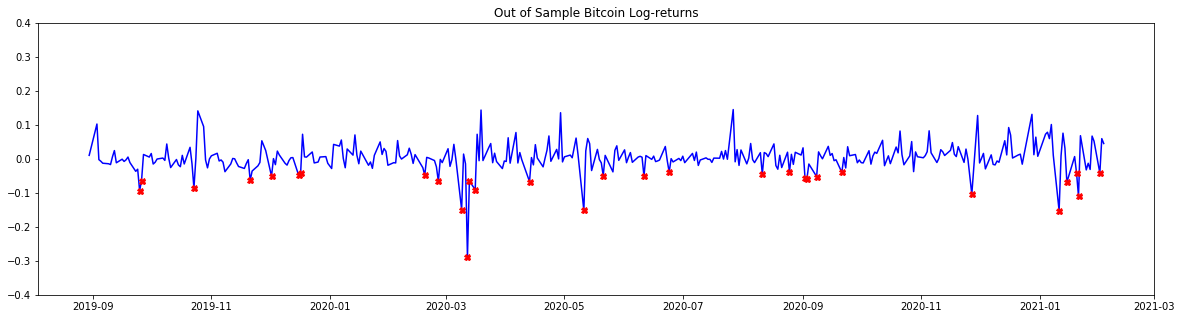

In [242]:
plt.figure(figsize=(20,5))
q=0.1
plt.title('Out of Sample Bitcoin Log-returns')
# print(np.sum(_id))
# _id = (rs<=np.quantile(rs,q)) & (rf<=np.quantile(rf,q)) 
_id = (rs<=np.quantile(rs,30/len(rs))) # 30 smallest rs

plt.plot(rs, 'b')
# plt.plot(rf, 'b')
# _id = (rs<=np.quantile(rs,q)) & (rf<=np.quantile(rf,q)) 
plt.plot(rs[_id],'rX')
plt.ylim((-0.4,0.4))

# plt.plot(rf[_id],'bX')
plt.savefig('../latex/_pics/OOSBitcoin.png', transparent=True)
# _id = (rs>np.quantile(rs,1-q)) & (rf>np.quantile(rf,1-q)) 
# plt.plot(rs[_id],'rX')
# plt.plot(rf[_id],'bX')

In [40]:
# plt.figure(figsize=(20,5))
# plt.plot(rs, 'r')
# q = 0.1

# rs_U = rs.loc[rs<=np.quantile(rs,q)]
# plt.plot(np.array(rs_U.index),np.array(rs_U),'rx')

# rs_L = rs.loc[rs>np.quantile(rs,1-q)]
# plt.plot(np.array(rs_L.index),np.array(rs_L),'r+')

# rf_U = rf.loc[rf<=np.quantile(rf,q)]
# plt.plot(np.array(rf_U.index),np.array(rf_U),'bx')

# rf_L = rf.loc[rf>np.quantile(rf,1-q)]
# plt.plot(np.array(rf_L.index),np.array(rf_L),'b+')

# plt.plot(rf, 'b')

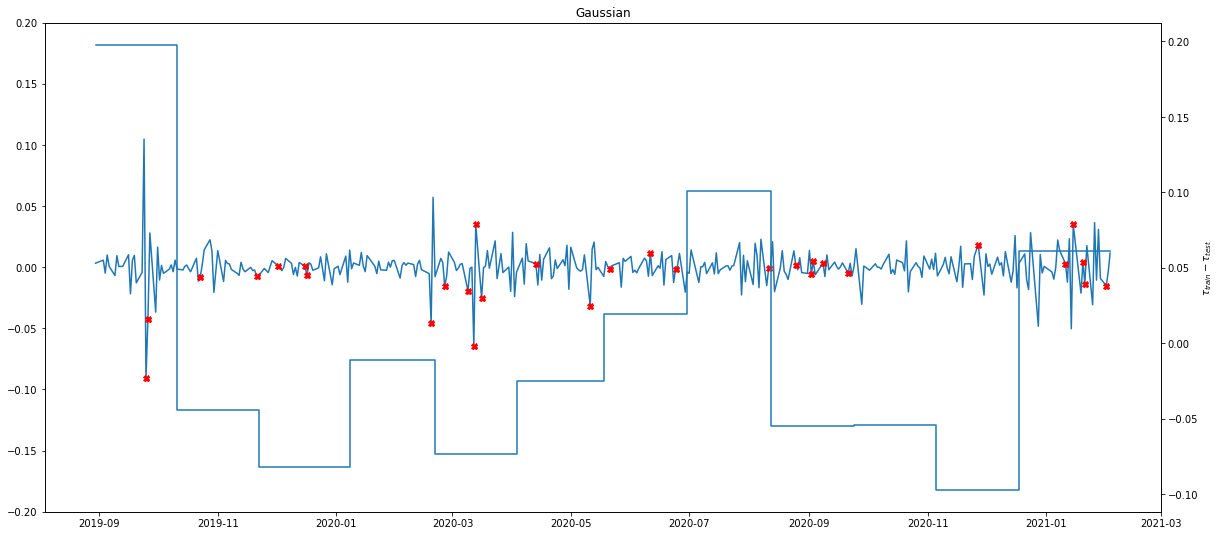

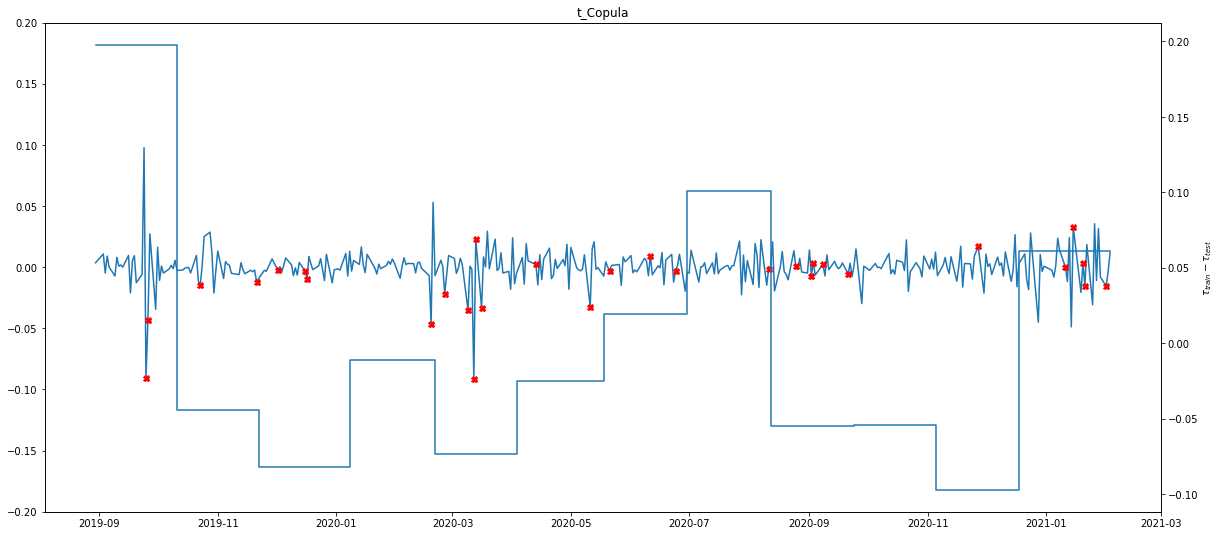

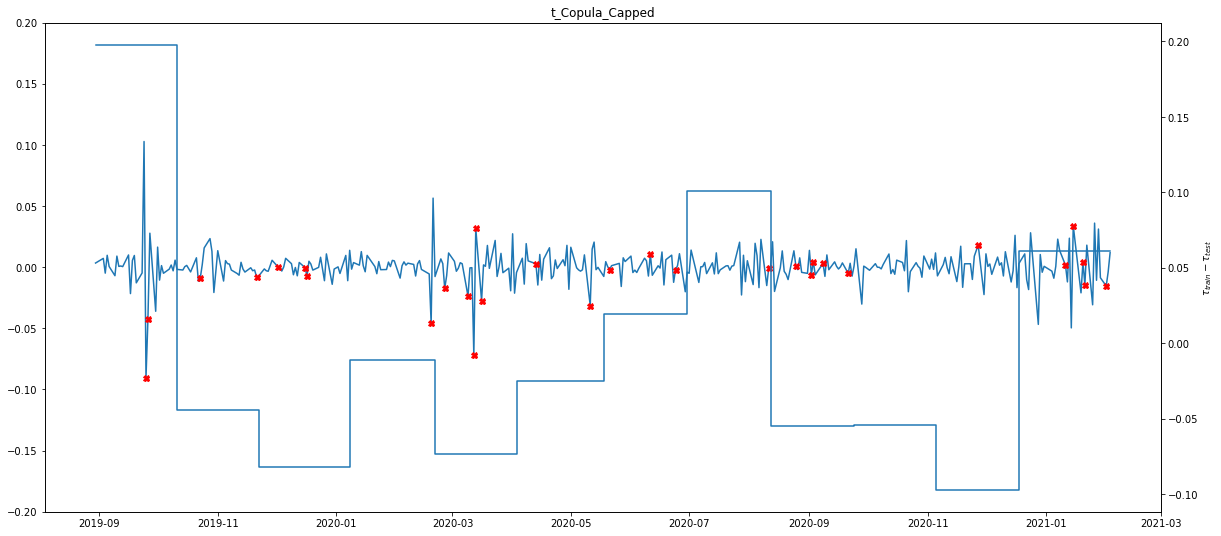

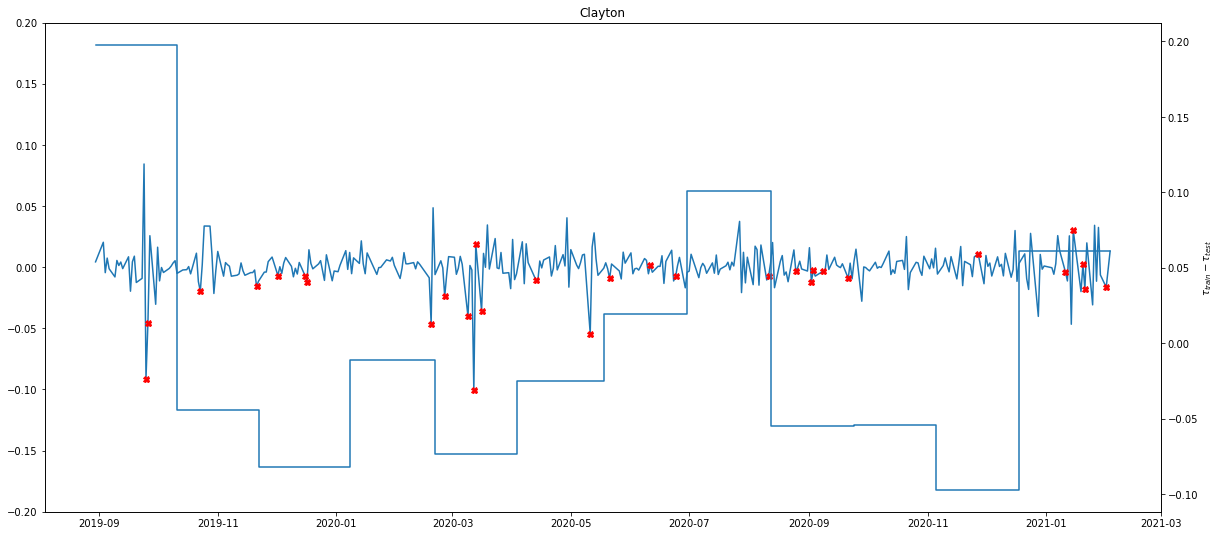

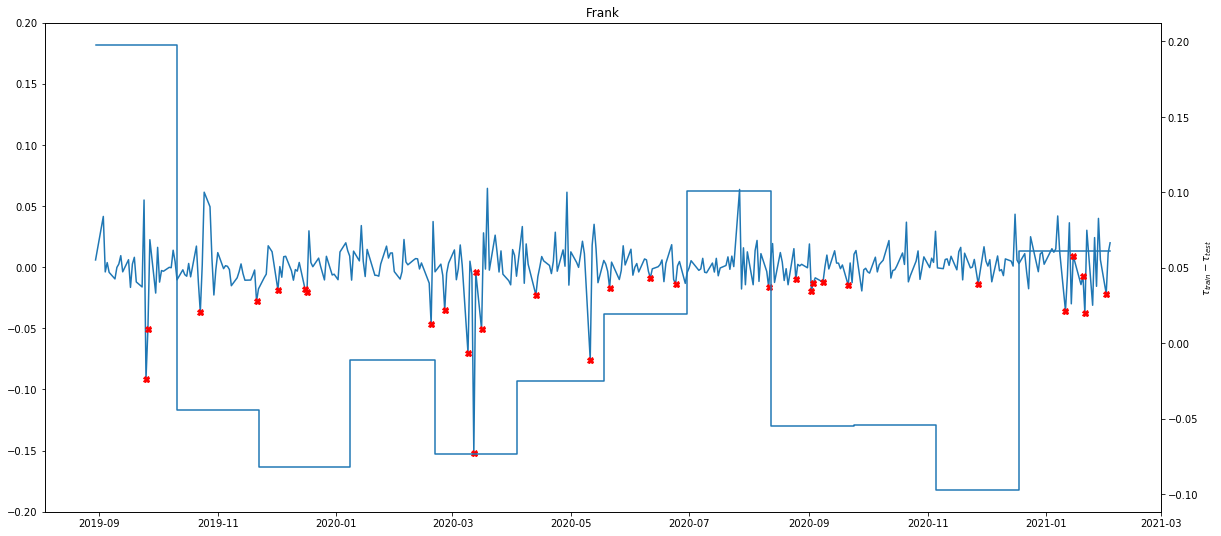

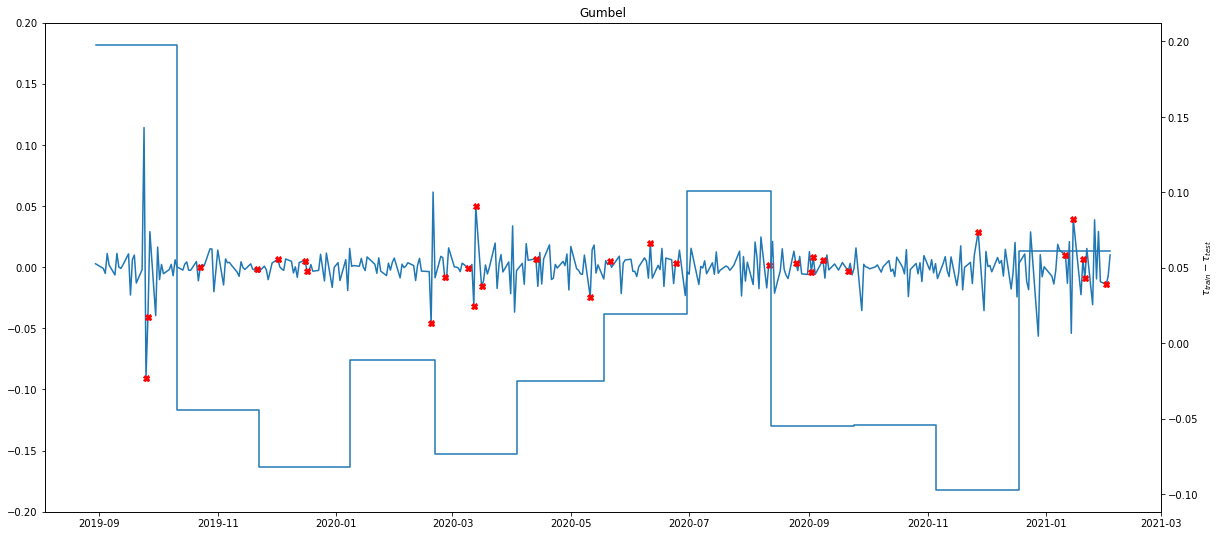

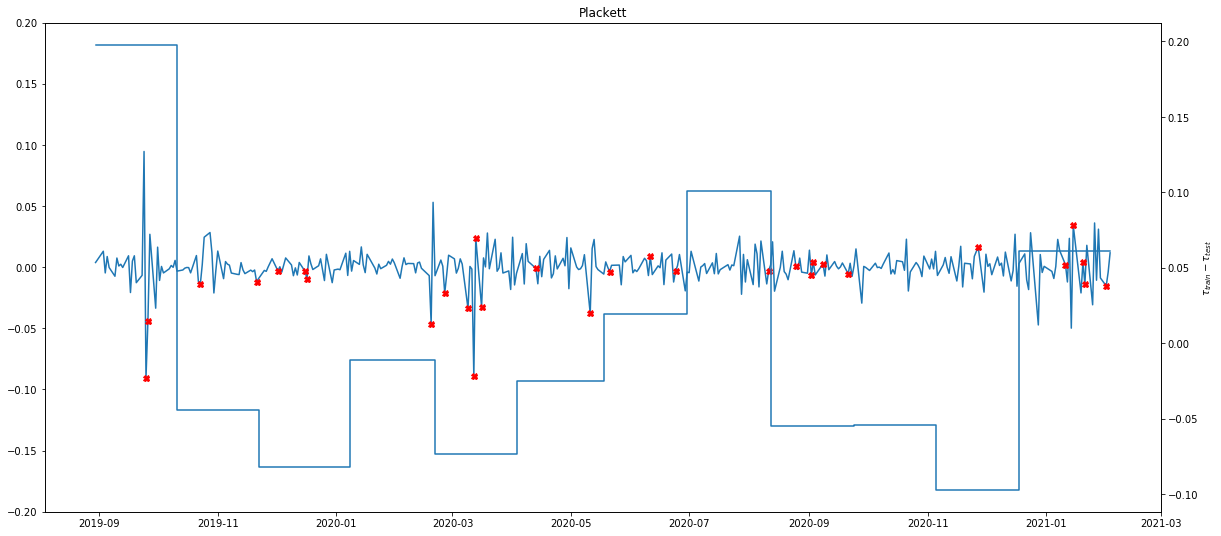

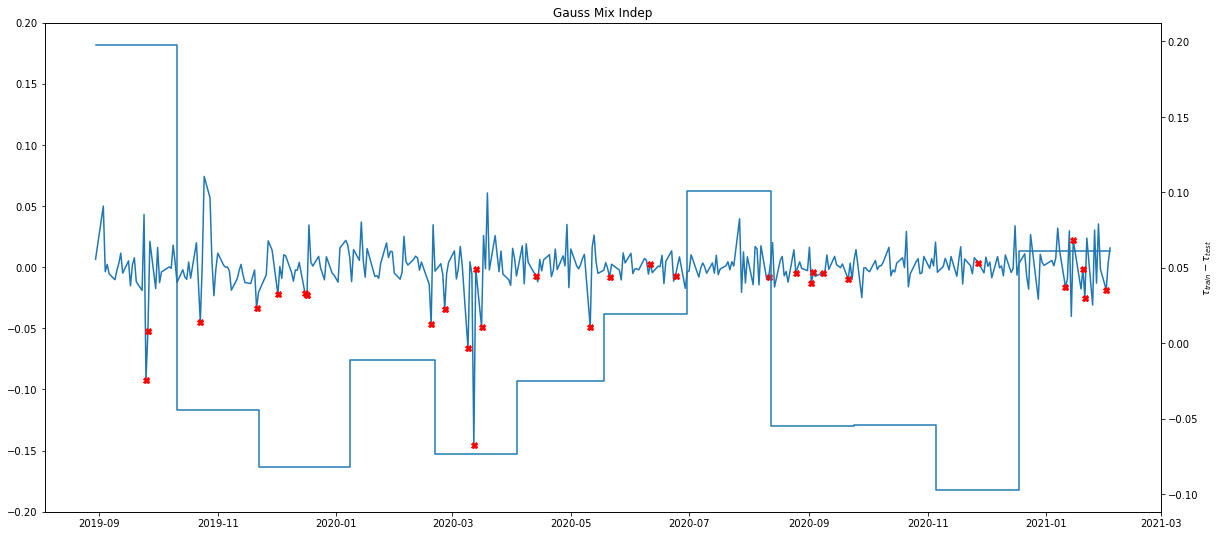

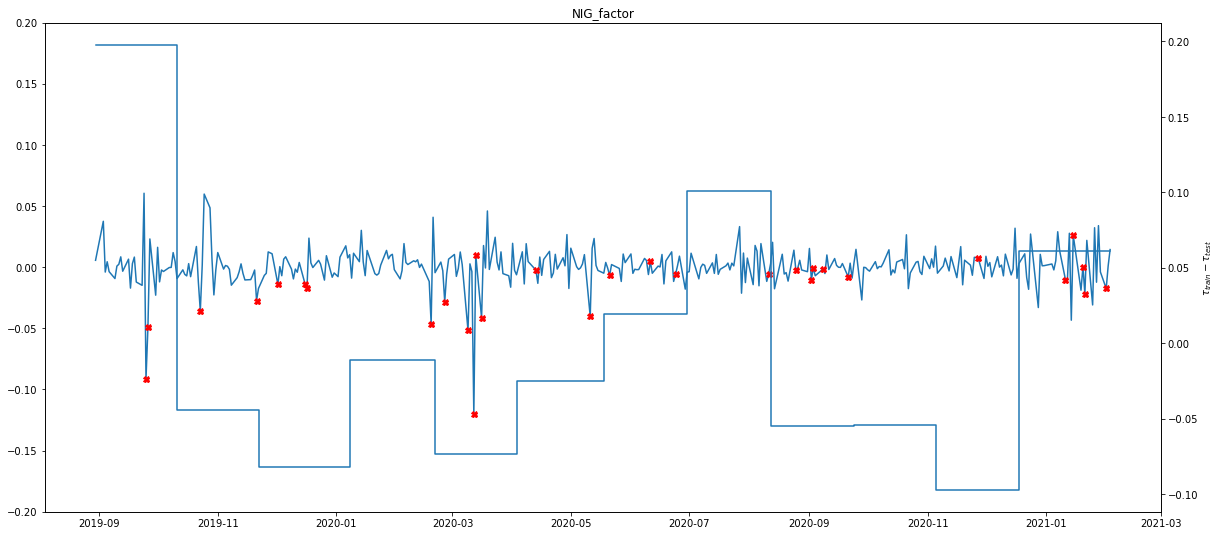

In [58]:
for i in range(len(Copula_names)):
    fig, ax1 = plt.subplots(figsize=(20,1*len(Copula_names)))
    ax2 = ax1.twinx()  
    C = Copula_names[i]
#     plt.figure(figsize=(20,5))
    ax1.set_title(Copula_names[i])
    ax1.plot(rh.loc[C,:])
    ax1.plot(rh.T.loc[_id, C], 'rX')
    ax1.set_ylim((-0.2,0.2))

    ax2.step(tau_arr.index, tau_arr)
    ax2.set_ylabel(r'$\tau_{train} - \tau_{test}$')

#     plt.plot(rh.loc[C,rs_L.index],'rx')
#     plt.plot(rh.loc[C,rs_U.index],'r+')
#     plt.plot(rh.loc[C,rf_L.index],'bx')
#     plt.plot(rh.loc[C,rf_U.index],'b+')
#     plt.ylim((-0.2,0.2))
# plt.hlines(np.quantile(rh.loc[Copula_names[0],:], q), xmin=rh.columns[0], xmax=rh.columns[-1])
# plt.hlines(np.quantile(rh.loc[Copula_names[0],:], 1-q), xmin=rh.columns[0], xmax=rh.columns[-1])

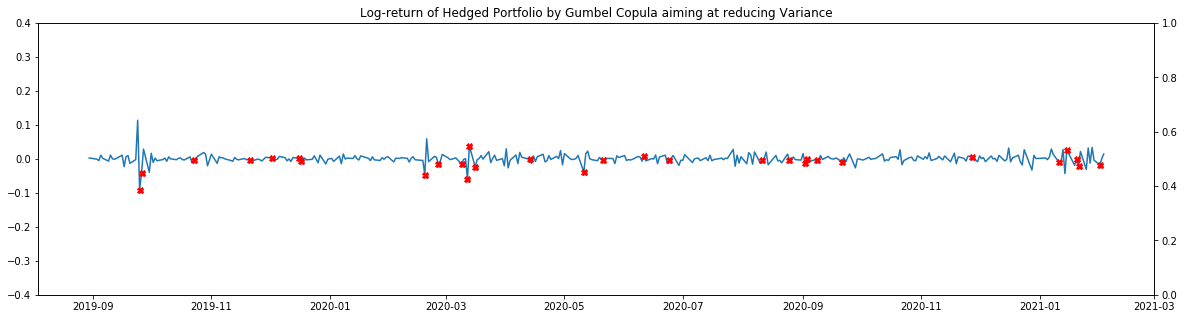

In [240]:
fig, ax1 = plt.subplots(figsize=(20,5))
ax2 = ax1.twinx()  
C = Copula_names[i]
#     plt.figure(figsize=(20,5))
ax1.set_title('Log-return of Hedged Portfolio by '+ Copula_names[i]+' Copula aiming at reducing '+rm)
ax1.plot(rh.loc[C,:])
ax1.plot(rh.T.loc[_id, C], 'rX')
ax1.set_ylim((-0.4,0.4))
plt.savefig('../latex/_pics/Gumbel_rh.png', transparent=True)
# _rh = rh.loc[C,:]
# S = pd.Series({'mean':np.mean(_rh), 
#  'std':np.std(_rh),
#  'skew':stats.skew(_rh),
#  'kurt':stats.kurtosis(_rh),
#  'max': np.max(_rh),
#  'UQ': np.quantile(_rh, 0.75),
#  'median': np.quantile(_rh, 0.5),
#  'LQ': np.quantile(_rh, 0.25), 
#  'min':np.min(_rh)})
# plt.figure(figsize=(5,5))
# sns.distplot(_rh)
# print(S)

In [30]:
dates = [pd.read_csv(data_path +'/test/'+file).iloc[-1,:].Date for file in ls]
end_date = _rh.index[-1]
h_4plot = pd.concat([OHR.loc[:, file].loc[:,rm] for file in ls],keys = dates, axis=1)
h_4plot = h_4plot.sort_index(axis=1)
h_4plot.loc[:,end_date] = h_4plot.iloc[:,-1]
a = go.Figure(go.Scatter(x=h_4plot.columns, y=h_4plot.loc[C,:], line= {"shape": 'hv'}))

NameError: name '_rh' is not defined

In [62]:
rh

Date,2019-08-30 00:00:00,2019-09-03 00:00:00,2019-09-04 00:00:00,2019-09-05 00:00:00,2019-09-06 00:00:00,2019-09-09 00:00:00,2019-09-10 00:00:00,2019-09-11 00:00:00,2019-09-12 00:00:00,2019-09-13 00:00:00,...,2021-01-21 00:00:00,2021-01-22 00:00:00,2021-01-25 00:00:00,2021-01-26 00:00:00,2021-01-27 00:00:00,2021-01-28 00:00:00,2021-01-29 00:00:00,2021-02-01 00:00:00,2021-02-02 00:00:00,2021-02-03 00:00:00
Gaussian,0.002814,-0.000512,-0.005088,0.011055,0.001617,-0.006374,0.011128,0.000193,-0.000938,0.001424,...,-0.021452,0.021754,-0.030867,0.032392,-0.012236,0.033850,-0.004096,-0.017336,0.000792,0.014302
t_Copula,0.002963,0.001511,-0.005030,0.010703,0.001336,-0.006530,0.010582,0.000309,-0.000439,0.001172,...,-0.022151,0.022120,-0.030879,0.032036,-0.012384,0.034112,-0.003653,-0.017527,0.001256,0.014546
t_Copula_Capped,0.002860,0.000115,-0.005070,0.010946,0.001530,-0.006422,0.010959,0.000229,-0.000783,0.001346,...,-0.021641,0.021853,-0.030870,0.032296,-0.012276,0.033921,-0.003976,-0.017388,0.000918,0.014368
Clayton,0.002818,-0.000457,-0.005086,0.011045,0.001610,-0.006378,0.011113,0.000196,-0.000924,0.001417,...,-0.021207,0.021625,-0.030863,0.032517,-0.012184,0.033758,-0.004252,-0.017269,0.000629,0.014216
Frank,0.005375,0.034122,-0.004092,0.005034,-0.003197,-0.009033,0.001791,0.002174,0.007601,-0.002891,...,-0.046530,0.034917,-0.031284,0.019606,-0.017549,0.043273,0.011835,-0.024174,0.017436,0.023065
Gumbel,0.002796,-0.000754,-0.005095,0.011097,0.001651,-0.006356,0.011193,0.000179,-0.000998,0.001454,...,-0.021792,0.021932,-0.030873,0.032219,-0.012308,0.033978,-0.003881,-0.017429,0.001018,0.014421
Plackett,0.002916,0.000873,-0.005048,0.010814,0.001425,-0.006481,0.010754,0.000272,-0.000596,0.001252,...,-0.023066,0.022601,-0.030894,0.031569,-0.012578,0.034456,-0.003071,-0.017776,0.001863,0.014866
Gauss Mix Indep,0.003498,0.008735,-0.004822,0.009447,0.000332,-0.007084,0.008635,0.000722,0.001342,0.000272,...,-0.026285,0.024290,-0.030947,0.029928,-0.013260,0.035666,-0.001027,-0.018654,0.004000,0.015991
NIG_factor,0.003571,0.009728,-0.004793,0.009275,0.000194,-0.007160,0.008367,0.000779,0.001587,0.000149,...,-0.025747,0.024008,-0.030938,0.030203,-0.013146,0.035464,-0.001368,-0.018507,0.003642,0.015803


In [38]:
df = pd.DataFrame(_rh).reset_index(drop=True)


AttributeError: 'DataFrame' object has no attribute 'Date'

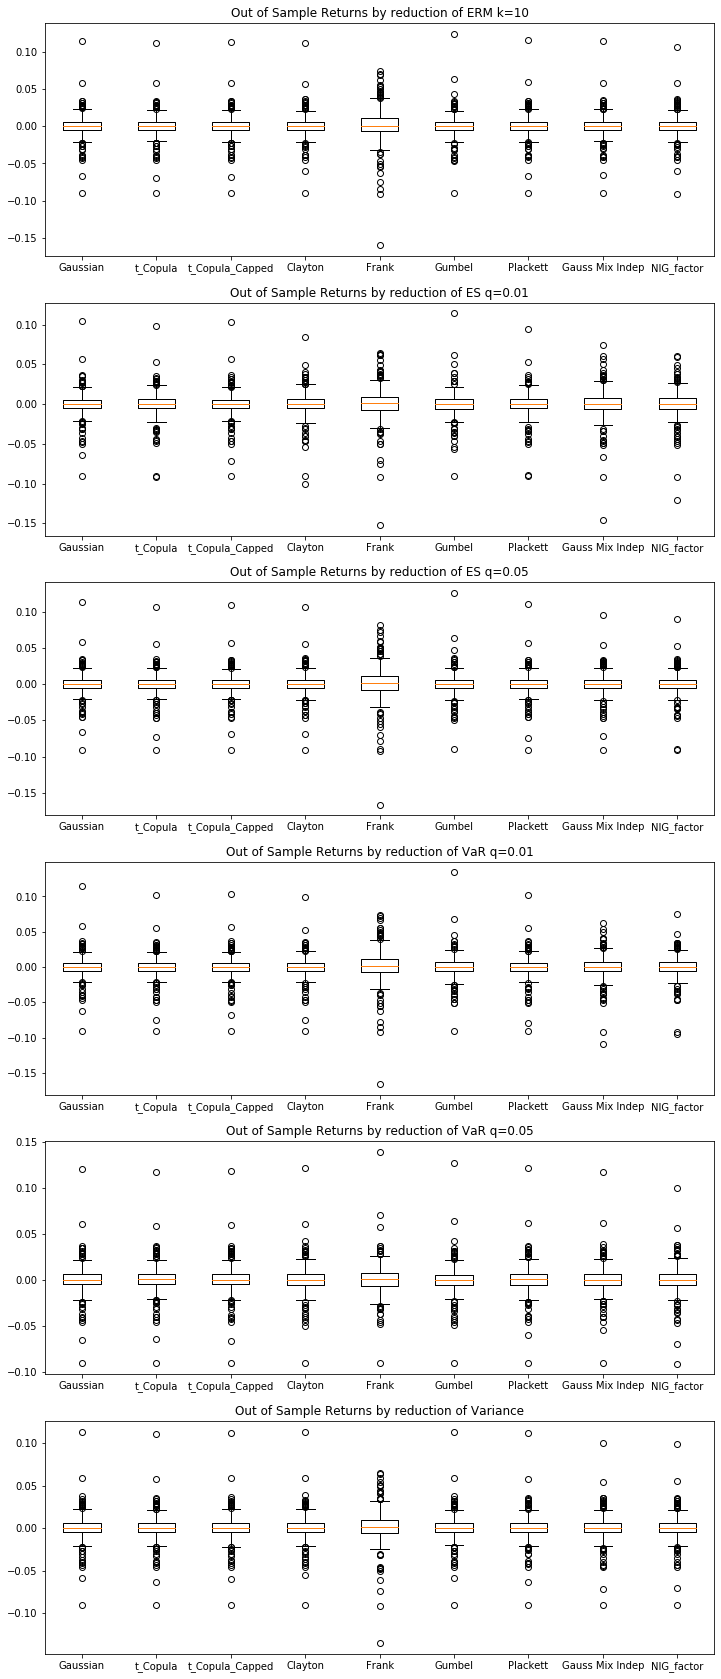

In [225]:
from plotly.subplots import make_subplots
fig, ax = plt.subplots(len(risk_measures), 1, figsize=(12,5*len(risk_measures)))
for i, rm in enumerate(risk_measures):
    rh_arr = []
    rs_arr = []
    rf_arr = []
    for file in ls:
        test = pd.read_csv(data_path +'/test/'+file)
        test.Date = pd.to_datetime(test.Date)
        rs = np.array(test.loc[:, config['spot_name']])
        rf = np.array(test.loc[:, config['future_name']])
        h_arr = OHR.loc[:,file].loc[:,rm]
        rh = rs - np.array(h_arr).reshape((len(h_arr),-1))*rf
        rh = pd.DataFrame(rh, index=Copula_names, columns=test.Date)
        rh_arr.append(rh)

        rs = pd.Series(rs, index=test.Date)
        rf = pd.Series(rf, index=test.Date)
        rs_arr.append(rs)
        rf_arr.append(rf)

    rh = pd.concat(rh_arr, axis=1)
    rh = rh.sort_index(axis=1)
    rs = pd.concat(rs_arr)
    rs = rs.sort_index()

    rf = pd.concat(rf_arr)
    rf = rf.sort_index()

    rh = rh.apply(pd.to_numeric)
    ax[i].boxplot(rh)
    ax[i].set_xticklabels(Copula_names)
    ax[i].set_title("Out of Sample Returns by reduction of %s" %rm)
    M = np.mean(rh, axis=1)
    STD = np.std(rh, axis=1)

    MAX = np.max(rh, axis=1)
    MAX_date = rh.isin(MAX).idxmax(axis=1)

    UQ = rh.apply(lambda x: np.quantile(x, 0.75, interpolation='higher'), axis=1)
    UQ_date = rh.isin(UQ).idxmax(axis=1)

    LQ = rh.apply(lambda x: np.quantile(x, 0.25, interpolation='higher'), axis=1)
    LQ_date = rh.isin(LQ).idxmax(axis=1)

    MIN = np.min(rh, axis=1)
    MIN_date = rh.isin(MIN).idxmax(axis=1)

    rh_stats = pd.concat([M, STD, MAX, MAX_date, UQ, UQ_date, LQ, LQ_date, MIN, MIN_date], axis=1)
    rh_stats.columns = ['mean', 'std', 
                        'max', 'max on',
                        'UQ', 'UQ on', 
                        'LQ', 'LQ on',
                        'min', 'min on']
    rh_stats.to_html(result_path+'rh_stats_%s.html'%rm)

    for C in Copula_names:
        _rh = rh.loc[C,:]

        fig = make_subplots(
            rows=3, cols=2,
            column_widths=[10, 10],
            row_heights=[10, 10, 10],
            specs=[[{"type":"xy","colspan": 2}, None],
                   [{"type":"xy","colspan": 2}, None],
                   [{"type": "histogram2d"}, {"type":"table"}]],
            subplot_titles=("Rh Time Series","OHR", "Histogram", "Rh Statistics"))
        
        # Line plot with extreme data points
        df = pd.DataFrame(_rh).reset_index()
        fig.add_trace(go.Scatter(x=df.loc[:,'Date'], y=df.loc[:,C]), row=1,col=1)
        fig.add_trace(go.Scatter(x=rh.T.loc[_id, C].index, y=rh.T.loc[_id, C],
                            mode='markers'))
        fig.update_yaxes(range=[-0.2, 0.2], row=1, col=1)

        
        # Step plot of h
        dates = [pd.read_csv(data_path +'/test/'+file).iloc[-1,:].Date for file in ls]
        end_date = _rh.index[-1]
        h_4plot = pd.concat([OHR.loc[:, file].loc[:,rm] for file in ls],keys = dates, axis=1)
        h_4plot = h_4plot.sort_index(axis=1)
        h_4plot.loc[:,end_date] = h_4plot.iloc[:,-1]
        fig.add_trace(go.Scatter(x=h_4plot.columns, y=h_4plot.loc[C,:], line= {"shape": 'hv'}),
                      row=2,col=1)
        fig.update_yaxes(range=[np.min(np.min(OHR))*.9, np.max(np.max(OHR))*1.1], row=2, col=1)

        # Table
        S = pd.Series({'mean':np.mean(_rh), 
         'std':np.std(_rh),
         'skew':stats.skew(_rh),
         'kurt':stats.kurtosis(_rh),
         'max': np.max(_rh),
         'UQ': np.quantile(_rh, 0.75),
         'median': np.quantile(_rh, 0.5),
         'LQ': np.quantile(_rh, 0.25), 
         'min':np.min(_rh)})
        df = pd.DataFrame(S)
        df = df.reset_index()
        df.columns = ['Statistics', 'Value']
        fig.add_trace(go.Table(
            header=dict(values=list(df.columns),
                        fill_color='paleturquoise',
                        align='left'),
            cells=dict(values=[df.iloc[:,0],df.iloc[:,1]],
                       fill_color='lavender',
                       align='left'))
        , row=3,col=2)

        uq = np.quantile(_rh, .75)
        lq = np.quantile(_rh, .25)
        bw = 1.06*min(np.std(_rh), (uq-lq)/1.34)*len(_rh)**(-1/5)

        distplfig = ff.create_distplot([np.array(_rh)],
                                       ['rh'], bin_size=bw, show_rug=False)

        fig.add_trace(go.Histogram(distplfig['data'][0],
                                   marker_color='red'
                                  ), row=3, col=1)

        fig.update_layout(height=1000, width=1200, title_text=C+' '+rm)

        fig.write_html(report_path+C+"_"+rm+".html")
        
plt.savefig(result_path+'Out of Sample Returns Boxplot.png', transparent=True)


In [141]:
M = np.mean(rh, axis=1)
STD = np.std(rh, axis=1)

MAX = np.max(rh, axis=1)
MAX_date = rh.isin(MAX).idxmax(axis=1)

UQ = rh.apply(lambda x: np.quantile(x, 0.75, interpolation='higher'), axis=1)
UQ_date = rh.isin(UQ).idxmax(axis=1)

LQ = rh.apply(lambda x: np.quantile(x, 0.25, interpolation='higher'), axis=1)
LQ_date = rh.isin(LQ).idxmax(axis=1)

MIN = np.min(rh, axis=1)
MIN_date = rh.isin(MIN).idxmax(axis=1)

rh_stats = pd.concat([M, STD, MAX, MAX_date, UQ, UQ_date, LQ, LQ_date, MIN, MIN_date], axis=1)
rh_stats.columns = ['mean', 'std', 
                    'max', 'max on',
                    'UQ', 'UQ on', 
                    'LQ', 'LQ on',
                    'min', 'min on']
rh_stats.to_html(result_path+'rh_stats_%s.html'%rm)

In [208]:
# import json
# with open('../src/configs/config_coingecko_future_v1_MM.json','r') as file:
#     config = json.load(file)
# config
# data_name = config['data_name']
# calibration_method  = config['calibration_method']
# OHR = pd.read_hdf('../results/'+data_name +'/'+calibration_method+'/best_h.h5')
# if not os.path.exists("../results/" + data_name + "/MLE/reports"):
# 	print("Create new folder for results")
# 	os.mkdir("../results/" + data_name + "/MLE/reports")
# 	os.mkdir("../results/" + data_name + "/MM/reports")
    
# if calibration_method == "MLE":
#     report_path = "../results/" + data_name + "/MLE/reports/"
#     result_path = "../results/" + data_name + "/MLE/"
# elif calibration_method == "MM":
#     report_path = "../results/" + data_name + "/MM/reports/"
#     result_path = "../results/" + data_name + "/MM/"


In [222]:
h_diff_arr = []
for rm in risk_measures:
    h = OHR.droplevel(0,1).loc[:, rm]
    h_diff = np.sum(np.abs(h.iloc[:,:-1] - h.iloc[:,1:]), axis=1)
    h_diff_arr.append(h_diff)

In [223]:
h_diff_df = pd.concat(h_diff_arr, axis=1)
h_diff_df.columns = risk_measures

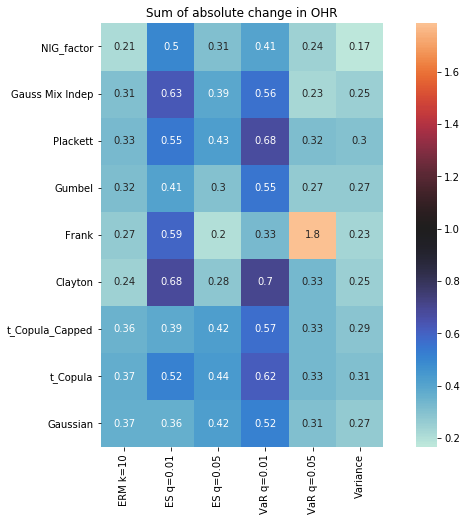

In [224]:
plt.figure(figsize=(9*1.3,6*1.3))
# sns.cubehelix_palette(as_cmap=True, reverse=True)
sns.heatmap(h_diff_df,square=True, center=True, annot=True)
plt.ylim(0,len(df_heatmap))
plt.title('Sum of absolute change in OHR')
plt.savefig(result_path+'Sum of absolute change in OHR.png', transparent=True)

In [226]:
rh

Date,2019-08-30 00:00:00,2019-09-03 00:00:00,2019-09-04 00:00:00,2019-09-05 00:00:00,2019-09-06 00:00:00,2019-09-09 00:00:00,2019-09-10 00:00:00,2019-09-11 00:00:00,2019-09-12 00:00:00,2019-09-13 00:00:00,...,2021-01-21 00:00:00,2021-01-22 00:00:00,2021-01-25 00:00:00,2021-01-26 00:00:00,2021-01-27 00:00:00,2021-01-28 00:00:00,2021-01-29 00:00:00,2021-02-01 00:00:00,2021-02-02 00:00:00,2021-02-03 00:00:00
Gaussian,0.002814,-0.000512,-0.005088,0.011055,0.001617,-0.006374,0.011128,0.000193,-0.000938,0.001424,...,-0.021452,0.021754,-0.030867,0.032392,-0.012236,0.033850,-0.004096,-0.017336,0.000792,0.014302
t_Copula,0.002963,0.001511,-0.005030,0.010703,0.001336,-0.006530,0.010582,0.000309,-0.000439,0.001172,...,-0.022151,0.022120,-0.030879,0.032036,-0.012384,0.034112,-0.003653,-0.017527,0.001256,0.014546
t_Copula_Capped,0.002860,0.000115,-0.005070,0.010946,0.001530,-0.006422,0.010959,0.000229,-0.000783,0.001346,...,-0.021641,0.021853,-0.030870,0.032296,-0.012276,0.033921,-0.003976,-0.017388,0.000918,0.014368
Clayton,0.002818,-0.000457,-0.005086,0.011045,0.001610,-0.006378,0.011113,0.000196,-0.000924,0.001417,...,-0.021207,0.021625,-0.030863,0.032517,-0.012184,0.033758,-0.004252,-0.017269,0.000629,0.014216
Frank,0.005375,0.034122,-0.004092,0.005034,-0.003197,-0.009033,0.001791,0.002174,0.007601,-0.002891,...,-0.046530,0.034917,-0.031284,0.019606,-0.017549,0.043273,0.011835,-0.024174,0.017436,0.023065
Gumbel,0.002796,-0.000754,-0.005095,0.011097,0.001651,-0.006356,0.011193,0.000179,-0.000998,0.001454,...,-0.021792,0.021932,-0.030873,0.032219,-0.012308,0.033978,-0.003881,-0.017429,0.001018,0.014421
Plackett,0.002916,0.000873,-0.005048,0.010814,0.001425,-0.006481,0.010754,0.000272,-0.000596,0.001252,...,-0.023066,0.022601,-0.030894,0.031569,-0.012578,0.034456,-0.003071,-0.017776,0.001863,0.014866
Gauss Mix Indep,0.003498,0.008735,-0.004822,0.009447,0.000332,-0.007084,0.008635,0.000722,0.001342,0.000272,...,-0.026285,0.024290,-0.030947,0.029928,-0.013260,0.035666,-0.001027,-0.018654,0.004000,0.015991
NIG_factor,0.003571,0.009728,-0.004793,0.009275,0.000194,-0.007160,0.008367,0.000779,0.001587,0.000149,...,-0.025747,0.024008,-0.030938,0.030203,-0.013146,0.035464,-0.001368,-0.018507,0.003642,0.015803
